In [1]:
from __future__ import print_function, division
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.pylabtools import figsize
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

# Challenger Space Shuttle Disaster

McLeish & Struthers (2012)

In [2]:
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                               usecols=[1, 2], missing_values="NA", delimiter=",")

In [3]:
# Drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:,1])]

In [4]:
# Plot it, as a function of temperature (the 1st column)
print("Temp (F), O-ring Failure?")
print(challenger_data)

Temp (F), O-ring Failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


In [5]:
figsize(12.5, 4);
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75,
           color='k', alpha=.5);
plt.yticks([0, 1]);
plt.ylabel("Damage Incidents");
plt.xlabel("Outside temperature (Fahrenheit)");
plt.title("Defects of the space shuttle O-rings vs T");

Probability of damage incidents occuring increases as the outside temperature decreases (from picture). 

"At Temperature $T$, what is the probability of a damage incident?"

We need $p(T)$ that is bounded between 0 and 1 : Logistic Functions.

$$p(T) = \frac{1}{(1 + e^{\beta T})}$$

$$\beta: 1,3,-5$$

In [6]:
def logistic(x, beta):
    return  1 / (1 + np.exp(beta * x))

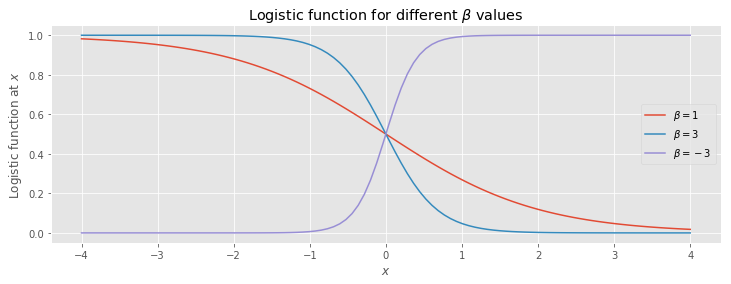

In [7]:
figsize(12, 4);

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r'$\beta = 1$');
plt.plot(x, logistic(x, 3), label=r'$\beta = 3$');
plt.plot(x, logistic(x, -5), label=r'$\beta = -3$');
plt.xlabel('$x$');
plt.ylabel("Logistic function at $x$");
plt.title('Logistic function for different $\\beta$ values');
plt.legend();

Problem: Probability changes only near 0.

We need to add bias term:
$$p(T) = \frac{1}{1 + e^{\beta T + \alpha}}$$

In [8]:
def logistic(x, beta, alpha=0):
    return 1 / (1 + np.exp(np.dot(beta, x) + alpha))

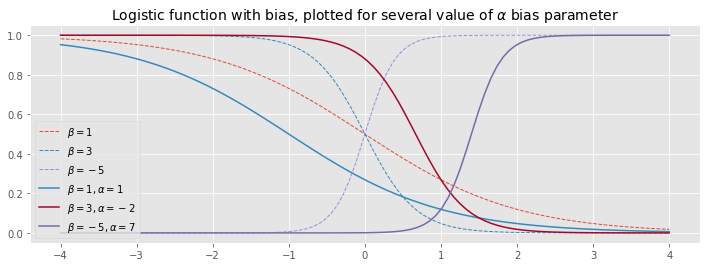

In [9]:
x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title("Logistic function with bias, plotted for several value of $\\alpha$ bias parameter", fontsize=14)
plt.legend(loc="lower left");

$\alpha, \beta$: Normal random variable.

## Normal Distribution

$$X \sim N(\mu, 1/\tau)$$

Random variable:

$$f(x|\tau) = \sqrt{\frac{\tau}{2\pi}} \text{ exp}\left(-\frac{\tau}{2}(x - \mu)^2\right)$$

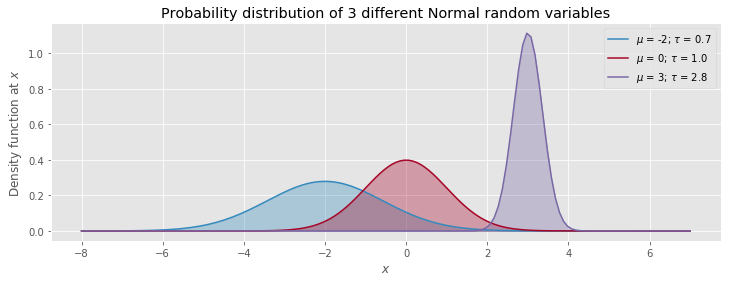

In [10]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale = 1/ _tau),
            label = '$\mu$ = %d; $\\tau$ = %.1f' %(_mu, _tau),
            color = _color);
    plt.fill_between(x, nor.pdf(x, _mu, scale = 1/_tau), color = _color,
                    alpha = .33);
    
plt.legend(loc="upper right");
plt.xlabel('$x$');
plt.ylabel('Density function at $x$');
plt.title('Probability distribution of 3 different Normal random variables');

* Expectation:
$$E[X|\mu, \tau] = \mu$$

* Variance:
$$\text{Var}(X|\mu, \tau) = \frac{1}{\tau}$$

In [11]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]

# Notice the 'value' here. We will explain it later
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1 / (1 + np.exp(beta * t + alpha))

Defect Incident:
$$D_{i} \sim \text{Ber}\left(P(T_{i})\right)$$

$i = 1,\cdots,N$

In [12]:
p.value

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [13]:
# Connect the probabilities in "p" with our observations through a 
# Bernoulli random variable
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)
model = pm.Model([observed, beta, alpha])

In [14]:
# mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

c:\users\user\anaconda3\envs\pymc\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 120000 of 120000 complete in 11.5 sec

In [15]:
alpha_samples = mcmc.trace('alpha')[:, None] # best to make them 1D
beta_samples = mcmc.trace('beta')[:, None]

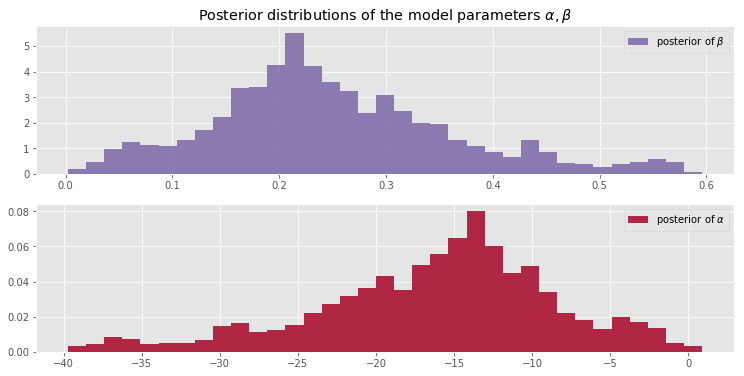

In [16]:
figsize(12.5, 6)

# histogram of the samples
plt.subplot(211);
plt.title(r'Posterior distributions of the model parameters \
$\alpha, \beta$');
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=.85,
        label=r'posterior of $\beta$', color='#7A68A6', normed=True);
plt.legend();

plt.subplot(212);
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=.85,
        label=r'posterior of $\alpha$', color='#A60528', normed=True);
plt.legend();

In [17]:
# Expected Probability for specific values
T = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_T = logistic(T.T, beta_samples, alpha_samples)
mean_prob_T = p_T.mean(axis=0)

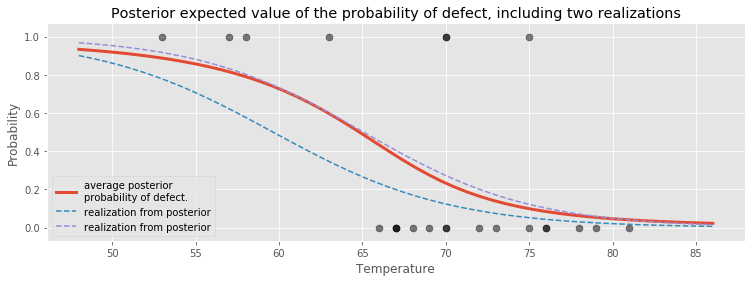

In [18]:
figsize(12.5, 4);
plt.plot(T, mean_prob_T, lw=3, label='average posterior \nprobability of defect.');
plt.plot(T, p_T[0, :], ls='--', label='realization from posterior');
plt.plot(T, p_T[-2, :], ls='--', label= 'realization from posterior');
plt.scatter(temperature, D, color='k', s=50, alpha=0.5);
plt.title('Posterior expected value of the probability of defect,\
 including two realizations');
plt.legend(loc='lower left');
plt.ylabel('Probability');
plt.xlabel('Temperature');

In [21]:
# 95% CI for each Temperature
from scipy.stats.mstats import mquantiles
# vectorized bottom and top 2.5% quantiles for "credible interval"
qs = mquantiles(p_T, [0.025, 0.975], axis=0);
plt.fill_between(T[:, 0], *qs, alpha=.7, color='#7A68A6');
plt.plot(T[:, 0], qs[0], )
plt.plot(T, mean_prob_T, lw=1, ls='--', color='k',
        label='average posterior \nprobability of defect');
plt.scatter(temperature, D, color='k', s=50, alpha=0.5);
plt.xlim(T.min(), T.max());
plt.ylim(-0.02, 1.02);
plt.xlabel('Temperature, $T$');
plt.ylabel('Probability estimate');
plt.title('Posterior probability of estimates, given temperature $T$');

Ex. $65^\circ$C, we can be 95% sure that the probability of defects lie between 0.25 - 0.75

What happened the day of Challenger Disaster?

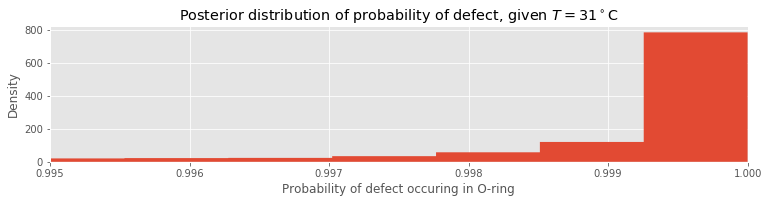

In [27]:
figsize(12.5, 2.5);

prob_31 = logistic(31, beta_samples, alpha_samples); # 31 deg temp. outside
plt.xlim(0.995, 1);
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled');
plt.title('Posterior distribution of probability of defect, given $T = 31^\circ$C');
plt.ylabel('Density');
plt.xlabel('Probability of defect occuring in O-ring');

## Is our model appropriate?

In [30]:
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

In [31]:
simulated_data = pm.Bernoulli("simulation_data", p)

In [42]:
simulated = pm.Bernoulli("bernoulli_sim", p)
N = 10000

In [43]:
mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.3 sec

In [44]:
simulations = mcmc.trace("bernoulli_sim")[:].astype(int)
print("Shape of the simulations array: ", simulations.shape)

Shape of the simulations array:  (10000L, 23L)


In [45]:
figsize(12.5, 6);
plt.title('Simulated datasets using posterior parameters');
for i in range(4):
    ax = plt.subplot(4, 1, i + 1);
    plt.scatter(temperature, simulations[1000 * i, :], color='k', s=50, alpha=.6);

## Separation Plots

For logistic regression fitting.

For each model, we calculate 